# Projeto PCD - Semelhança Genética Viral
Autores: Bruna Guedes; Jônatas de Oliveira; Luiza Davoli; Matheus Macedo


## Sumário

1. Introdução  
2. Bibliotecas

3. Funções

    3.1. numero_genomas

    3.2. selecao_virus

    3.3. buscar_genoma

    3.4. baixar_genoma

    3.5. rodar_muscle

    3.6. calcular_similaridade

    3.7. calculando_dstribuicoes

    3.8. plotar_matriz_triangular

5. Função Principal

6. Referências  

## 1. Introdução

## 2. Bibliotecas

Todas as bibliotecas, bem como módulos ou funções específicas utilizadas no funcionamento do nosso código estão listadas abaixo:

In [16]:
from Bio import Entrez, SeqIO, AlignIO
from pathlib import Path
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from collections import defaultdict
import os
from tkinter import *
from tkinter import ttk

## 3. Funções 

Abaixo definimos e explicamos todas as funções necessárias para o funcionamento do programa.

3.1 `buscar_genoma` : Essa função busca o vírus selecionado na base de dados do NCBI (National Center for Biotechnology Information). Para isso, a função recebe o nome do vírus, busca o Accession Code correspondente e retorna essa informação ao usuário. Esse é um passo muito importante, pois um mesmo vírus pode ter diferentes cepas e sequenciamentos, os quais terão diferentes códigos no NCBI. Caso o vírus não esteja na base de dados do site, a função informa o usuário sobre esse problema e requisita uma nova tentativa

In [17]:
def numero_genomas():

    numero = None

    # Esse bloco cria e configura a janela que será aberta pelo tkinter
    janela = Tk()
    janela.title('Painel interativo')
    janela.geometry('600x100+100+100')
    janela.attributes('-topmost', 1)
    conteudo = ttk.Frame(janela, padding=(3,12))
    titulo = ttk.Label(conteudo, text="Número de genomas que se deseja comparar")

    # Permite que o usuário digite em uma caixa de texto, realizando um input
    caixa_texto = ttk.Entry(conteudo)

    # Cria botões interativos com as funções desejadas
    def comando():
        nonlocal numero
        numero = caixa_texto.get()
        janela.destroy()

        return numero
    
    ok = ttk.Button(conteudo, text="OK", command=comando)

    # Ajusta visualmente o tamanho e distância de cada componente da janela
    conteudo.grid(column=0, row=0, sticky=(N, S, E, W))
    titulo.grid(column=2, row=0, columnspan=4, sticky=(N, W), padx=5)
    caixa_texto.grid(column=0, row=1, columnspan=6, sticky=(N,E,W), pady=5, padx=5)
    ok.grid(column=4, row=3)

    janela.columnconfigure(0, weight=2)
    janela.rowconfigure(0, weight=2)
    conteudo.rowconfigure(1, weight=2)
    conteudo.columnconfigure(0, weight=4)
    conteudo.columnconfigure(1, weight=4)
    conteudo.columnconfigure(2, weight=4)
    conteudo.columnconfigure(3, weight=2)
    conteudo.columnconfigure(4, weight=2)

    # Executa o código, permitindo que a janela seja aberta
    janela.mainloop()

    return numero

In [33]:
def selecao_virus():
    nome_do_virus = None  # variável acessível fora de `comando`

    janela = Tk()
    janela.title('Painel interativo')
    janela.geometry('600x100+100+100')
    janela.attributes('-topmost', 1)
    conteudo = ttk.Frame(janela, padding=(3,12))
    titulo = ttk.Label(conteudo, text="Nome do Vírus em Inglês")
    caixa_texto = ttk.Entry(conteudo)

    def comando():
        nonlocal nome_do_virus
        nome_do_virus = caixa_texto.get()
        janela.destroy()

    ok = ttk.Button(conteudo, text="OK", command=comando)

    conteudo.grid(column=0, row=0, sticky=(N, S, E, W))
    titulo.grid(column=2, row=0, columnspan=4, sticky=(N, W), padx=5)
    caixa_texto.grid(column=0, row=1, columnspan=6, sticky=(N,E,W), pady=5, padx=5)
    ok.grid(column=4, row=3)

    janela.columnconfigure(0, weight=2)
    janela.rowconfigure(0, weight=2)
    conteudo.rowconfigure(1, weight=2)
    for i in range(5):
        conteudo.columnconfigure(i, weight=2)

    janela.mainloop()

    return nome_do_virus

In [19]:
def buscar_genoma(nome_virus):
    
    Entrez.email = "computandocombiopy@gmail.com"
    termo_de_busca = f"{nome_virus} complete genome"
    busca = Entrez.esearch (db = "nucleotide", term = termo_de_busca, retmax = 1, sort = "relevance")
    resultado = Entrez.read(busca)
    busca.close()
    
    lista_ids = (resultado["IdList"])

    if not lista_ids:
        print(f"Não há um vírus {nome_virus} no NCBI. Tente outra vez!")

    id_do_virus = lista_ids[0]

    resumo = Entrez.esummary(db="nucleotide", id=id_do_virus)
    dados = Entrez.read(resumo)
    resumo.close()

    acession = dados[0]["AccessionVersion"]

    print(acession)

    return acession
    

   

3.2 `baixar_genoma`: essa função recebe um Accession Code e faz o download do genoma completo associado com ele, disponibilizado pelo NCBI como um arquivo `.fasta`. Ela guarda os arquivos baixados na pasta `data/genomes` e, posteriamente, faz o pré-processamento do genoma, reduzindo-o para 3000 pares de base e inserindo-o em outro arquivo chamado `todos_genomas.fasta`. 

In [20]:
def baixar_genoma(iden, output_folder=Path("data")/"genomes", output_file=Path("data/genomes/todos_genomas.fasta"), limite_pb=3000):
    Entrez.email = "computandocombiopy@gmail.com"
    output_file.parent.mkdir(parents=True, exist_ok=True)
    output_folder.mkdir(parents=True, exist_ok=True)
    filename=output_folder/f"{iden}.fasta"
    
    try:
        # Baixa o genoma completo em formato FASTA
        handle = Entrez.efetch(db="nucleotide", id=iden, rettype="fasta", retmode="text", sort = "lenght")
        fasta_texto = handle.read()
        handle.close()

        if not fasta_texto:
            print("Error: Resposta vazia do NCBI")
        else: 
            with open(filename, "w") as output:
                output.write(fasta_texto)
            print(f"Salvo em {filename}")

        if not fasta_texto.strip():
            print(f"Nenhum dado retornado para {iden}")
            return
        
        # Lê o conteúdo como um objeto SeqRecord
        seq_io = StringIO(fasta_texto)
        record = SeqIO.read(seq_io, "fasta")

        # Trunca a sequência para no máximo 3000 pb
        record.seq = record.seq[:limite_pb]

        # Escreve em um arquivo FASTA único (modo append)
        with open(output_file, "a") as output_handle:
            SeqIO.write(record, output_handle, "fasta")

        print(f"{iden} salvo (limitado a {limite_pb} pb) em {output_file}")

    except Exception as e:
        print(f"Erro ao processar {iden}: {e}")

3.3 `rodar_muscle` : 

In [21]:
def rodar_muscle(entrada_fasta, saida_fasta): 
    
    # Acessa o executável do MUSCLE
    muscle_exe = "muscle-win64.v5.3.exe"
    
    # Alinha o arquivo de entrada e coloca os dados de saída no arquivo criado pelo executável
    comando = [muscle_exe, "-align", entrada_fasta, "-output", saida_fasta]
    
    # Tratamento de erro
    try: 
        resultado = subprocess.run(comando, check=True, capture_output=True, text=True) 
        print("MUSCLE finalizado com sucesso.")
        print("STDOUT:", resultado.stdout)
        print("STDERR:", resultado.stderr)
    except subprocess.CalledProcessError as e:
        print("Erro ao rodar MUSCLE:")
        print("STDOUT:", e.stdout)
        print("STDERR:", e.stderr)
        
        # Imprime o erro novamente, além de interromper o programa, impedindo que o erro se prolongue
        raise 

3.4 `calcular_similaridades`: 

In [22]:
def calcular_similaridades(alinhado_fasta):
    entrada = AlignIO.read(alinhado_fasta, "fasta")

    seqs = []
    nomes = []

    for reg in entrada:
        seqs.append(str(reg.seq))
        nomes.append(reg.id)

    n = len(seqs)

    matriz = np.full((n, n), 0, dtype = float)

    for virus1 in range(n):
        for virus2 in range(n):
            bases_iguais = sum(a==b for a,b in zip(seqs[virus1], seqs[virus2]))
            total_bases = len(seqs[virus1])
            if total_bases > 0:
                similaridade = bases_iguais / total_bases
            else:
                similaridade = 0
            matriz[virus1, virus2] = similaridade
    
    return nomes, matriz

3.5 Aqui temos 3 funções que operam em conjunto:
1.  `obtendo_fasta` recebe como argumento o caminho de uma pasta com arquivos `.fasta`e devolve uma lista com os caminhos de todos os arquivos desse tipo que existem no local;
1. `calculo_dist` recebe como argumento o caminho de um arquivo `.fasta` e retorna um valor com a porcentagem de pares de base C + G que existem no genoma, bem como um dicionário com o percentual de cada par de base presente no genoma. 
1. `calculando_distribuicoes` não recebe argumentos e, fazendo uso das funções acima descritas, retorna dois dicionários. O primeiro deles tem como chaves os Accession Codes de cada genoma e como valores o percentual de C+G presentes. O segundo dicionário também tem as mesmas chaves, mas os valores são dicionários no seguinte formato {'A':x%, 'U':y%, 'C':z%, 'G':w%} para genomas de RNA ou {'A':x%, 'T':y%, 'C':z%, 'G':w%} para genomas de DNA. 

In [23]:

#Obtendo todos arquivos da pasta genomes (retorna uma lista com objetos path)
def obtendo_fasta(fasta_dir: Path) -> list[Path]:
  #Checando se o diretório existe ou não
  if not fasta_dir.exists():
    raise FileNotFoundError(f"Diretório de arquivos FASTA não encontrado: {fasta_dir}")
#verificação dupla agora de se é realmente um diretório e não um arquvio
  if not fasta_dir.is_dir():
    raise NotADirectoryError(f"O caminho não é um diretório: {fasta_dir}")
  return list(fasta_dir.glob('*.fasta'))+list(fasta_dir.glob('*.FASTA'))

  
def calculo_dist(fasta_file: Path):
  #inicializo como defaultdict (me ajuda a manejar o dicionário, execução
  #+rápida)
  contador_bases=defaultdict(int)
  total_bases=0
  """A função calcula a porcentagem de bases em uma sequência de RNA.
  Os retornos são (percentual_gc, {'A':x%, 'U':y%, 'C':z%, 'G':w%})
  """
  #Abro o arquivo e chamo de f
  with open(fasta_file, 'r') as f:
    for linha in f:
      if linha.startswith('>'):
          continue
    #Por que strip() e upper? Retiro qualquer espaço ou caracter de linha nova
    #Converto tudo pra maiúsculo.
      for base in linha.strip().upper():
        #PARA RNA PELO AMOR
        if base in 'ACGUT':
          contador_bases[base]+=1
          total_bases+=1

  base_percentuais={
    base:(count/total_bases)*100 
    for base, count in contador_bases.items()
  }

  perc_gc= base_percentuais.get('G', 0) + base_percentuais.get('C',0)
  
  return perc_gc, base_percentuais
  
def calculando_distribuicoes():
  porcentagensCG={}
  lista_porcentagens={}
  #Obtendo o caminho em que esse código está sendo executado
  raiz_projeto = Path(os.getcwd())

  #Encontro o caminho para a pasta genomes que tem os arquivos .fasta
  fasta_dir= raiz_projeto / "data/genomes"

  try: 
    #Obtenho todos os arquivos que vem do diretório 
    fasta_files=obtendo_fasta(fasta_dir)

    #Quero saber se eu puxei os arquivos do diretório:
    if not fasta_files:
      print(f"Sem arquivos fasta em {fasta_dir}")
      #Sai do código prematuramente (não tinha nada, tem que sair)
      return
    #Achei arquivos!!
    print(f"Encontrados arquivos .fasta")

    #Percorro os arquivos e adiciono nos dicionários um par
    #código do virus/porcentagemC e codigo do virus/lista_porcentagens
    for fasta_file in fasta_files:
      #perc_cg tem a porcentagem de CG e lista_perc tem as porcentagens de cada
      #par de base
      if fasta_file.stem != "todos_genomas":
        perc_gc, lista_perc=calculo_dist(fasta_file)
        porcentagensCG[fasta_file.stem]=perc_gc
        lista_porcentagens[fasta_file.stem]=lista_perc

  except Exception as e:
    print(f"Erro {str(e)}", file=sys.stderr)
    sys.exit(1)
      
  return porcentagensCG, lista_porcentagens

3.6  `plotar_matriz_triangular`: 

In [24]:
def plotar_matriz_triangular(nomes, matriz):

    # Garante que a matriz é um array NumPy, necessário para facilitar as operações matemáticas e criação de gráficos
    matriz_np = np.array(matriz) 
    
    # Máscara para esconder a parte superior da matriz (acima da diagonal)
    matriz_bool = np.ones_like(matriz_np, dtype=bool)
    mascara = np.triu(matriz_bool)
    
    # Módulo para criar uma figura com tamanho definido em polegadas (largura, altura)
    plt.figure(figsize=(8, 6)) 
    sns.heatmap(matriz_np, annot=True, fmt=".2f", mask=mascara,
                xticklabels=nomes, yticklabels=nomes,
                cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Similaridade"},
                vmin=0.001, vmax=1.0)

    plt.title("Matriz de Similaridade Genômica", fontsize=16)
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 4. Função Principal 

A função principal, responsável por, através do acionamento das outras, produzir o resultado final do código chama-se `comparar_genomas_geral` e recebe como argumento uma lista de strings que contém os vírus que terão seus genomas baixados, alinhados, comparados e associados por uma matriz triangular de similaridade. 

Você quer comparar 3 vírus.
os virus são ['Ebola', 'Dengue', 'Sars-cov-2']
Baixando o genoma de Ebola
NC_002549.1
Baixando o genoma de Dengue
AB189128.1
Baixando o genoma de Sars-cov-2
MZ054892.1
Salvo em data\genomes\NC_002549.1.fasta
NC_002549.1 salvo (limitado a 3000 pb) em data\genomes\todos_genomas.fasta
Salvo em data\genomes\AB189128.1.fasta
AB189128.1 salvo (limitado a 3000 pb) em data\genomes\todos_genomas.fasta
Salvo em data\genomes\MZ054892.1.fasta
MZ054892.1 salvo (limitado a 3000 pb) em data\genomes\todos_genomas.fasta
MUSCLE finalizado com sucesso.
STDOUT: 
STDERR: 
muscle 5.3.win64 [d9725ac]  16.6Gb RAM, 14 cores
Built Nov 10 2024 22:59:05
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

[align data/genomes/todos_genomas.fasta]
Input: 3 seqs, avg length 3000, max 3000, min 3000

00:00 4.6Mb    33.3% Derep 1 uniques, 0 dupes
00:00 4.6Mb   100.0% Derep 3 uniques, 0 dupes

00:00 4.6Mb  CPU has 14 cores, running 14 threads
00:00 5.0Mb    33.3% Calc posteriors
00:0

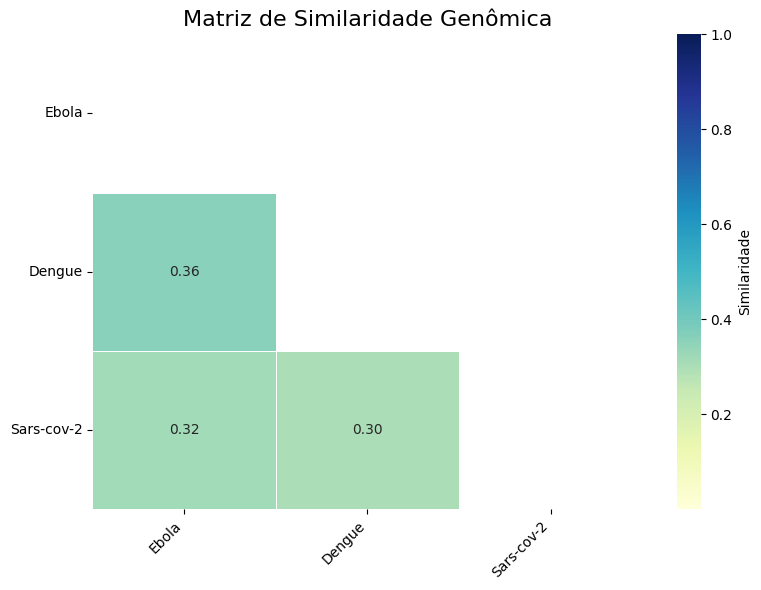

Encontrados arquivos .fasta
Porcentagens de G+C em cada genoma:
  AB189128.1: 46.88%
  MZ054892.1: 37.96%
  NC_002549.1: 41.07%

Composição dos genomas por percentual de bases:
  AB189128.1:
    A: 32.05%
    G: 26.01%
    T: 21.07%
    C: 20.86%
  MZ054892.1:
    C: 18.32%
    A: 29.89%
    T: 32.16%
    G: 19.64%
  NC_002549.1:
    C: 21.28%
    G: 19.79%
    A: 31.97%
    T: 26.96%


In [43]:
def comparar_genomas_geral(nome_virus):

    lista_acessions = []

    pasta = "data/genomes"

    # Apaga todos os arquivos da pasta antes de continuar
    for arquivo in os.listdir(pasta):
        caminho_arquivo = os.path.join(pasta, arquivo)
        if os.path.isfile(caminho_arquivo):
            os.remove(caminho_arquivo)

    numero = numero_genomas()
    print(f"Você quer comparar {numero} vírus.")

    if int(numero) < 2 or int(numero) > 15:
        raise ValueError("Você deve comparar no mínimo dois e no máximo quinze vírus")

    virus_escolhidos = []
    
    for i in range(int(numero)):
        virus = selecao_virus()
        virus_escolhidos.append(virus)
    print(f"os virus são {virus_escolhidos}")

    for virus in virus_escolhidos:
        print(f"Baixando o genoma de {virus}")
        lista_acessions.append(buscar_genoma(virus))
    for iden in lista_acessions:
        baixar_genoma(iden)
        
    rodar_muscle("data/genomes/todos_genomas.fasta", "data/genomes/genomas_alinhados")
    nomes, matriz = calcular_similaridades("data/genomes/genomas_alinhados")
    plotar_matriz_triangular(virus_escolhidos, matriz)
    porcentagensCG, lista_porcentagens=calculando_distribuicoes()
    print("Porcentagens de G+C em cada genoma:")
    for seq_id, gc_percent in porcentagensCG.items():
        print(f"  {seq_id}: {gc_percent:.2f}%")

    print("\nComposição dos genomas por percentual de bases:")
    for seq_id, bases in lista_porcentagens.items():
        print(f"  {seq_id}:")
        for base, percent in bases.items():
            print(f"    {base}: {percent:.2f}%")

comparar_genomas_geral(nome_virus)
    

## 5. Referências

Sequenciamento genômico: no rastro do vírus. Disponível em: <https://agencia.fiocruz.br/sequenciamento-genomico-no-rastro-do-virus>. Acesso em: 11 jun. 2025.

Accessing NCBI’s Entrez databases — Biopython 1.85 documentation. Disponível em: <https://biopython.org/docs/latest/Tutorial/chapter_entrez.html#chapter-entrez>. Acesso em: 11 jun. 2025.

NATIONAL CENTER FOR BIOTECHNOLOGY INFORMATION. Our Mission - NCBI. Disponível em: <https://www.ncbi.nlm.nih.gov/home/about/mission/>.

‌DOS, C. GenBank. Disponível em: <https://pt.wikipedia.org/wiki/GenBank>. Acesso em: 11 jun. 2025.

‌BIOPYTHON. Biopython · Biopython. Disponível em: <https://biopython.org/>.

Biopython Documentation — Biopython 1.85 documentation. Disponível em: <https://biopython.org/docs/latest/index.html#>. Acesso em: 11 jun. 2025.

‌Cock, P. J. A., Antao, T., Chang, J. T., Chapman, B. A., Cox, C. J., Dalke, A., Friedberg, I., Hamelryck, T., Kauff, F., Wilczynski, B., & de Hoon, M. J. L. (2009). Biopython: freely available Python tools for computational molecular biology and bioinformatics. Bioinformatics, 25(11), 1422–1423.

‌OPENAI. ChatGPT (versão GPT-4) [ferramenta de inteligência artificial]. Disponível em: https://chat.openai.com/. Acesso em: 11 jun. 2025.

WIKIPEDIA CONTRIBUTORS. Sequence alignment. Disponível em: <https://en.wikipedia.org/wiki/Sequence_alignment>.

WIKIPEDIA CONTRIBUTORS. MUSCLE (alignment software).

INTRODUÇÃO, 3. 1. Alinhamento de Seqüências. Disponível em: <https://professor.pucgoias.edu.br/SiteDocente/admin/arquivosUpload/18497/material/Cap.%203%20Alinhamento%20de%20sequ%C3%AAncias.pdf>. Acesso em: 11 jun. 2025.

The module for multiple sequence alignments, AlignIO. Disponível em: <https://biopython.org/wiki/AlignIO>. Acesso em: 11 jun. 2025.

Introduction to NumPy. Disponível em: <https://www.w3schools.com/python/numpy/numpy_intro.asp>. Acesso em: 11 jun. 2025.



Edgar, R. C. (2004). MUSCLE: a multiple sequence alignment method with reduced time and space complexity. BMC Bioinformatics, 5, 113. 


TkDocs home. Disponível em: <https://tkdocs.com/index.html>. Acesso em: 18 jun. 2025.